In [33]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy.stats as scis

### iJO1366 raw data

In [140]:
class ReactionNode:
    def __init__(self):
        self.id = ""
        self.reagents = []
        self.products = []
    
    def __init__(self, react_id, reagents, products):
        self.id = react_id
        self.reagents = reagents
        self.products = products

In [161]:
class Arc:
    def __init__(self):
        self.start = None
        self.end = None
        
    def __init__(self, startNode, endNode):
        self.start = startNode
        self.end = endNode
    
    def start(self, startNode):
        self.start = startNode
    
    def end(self, endNode):
        self.end = endNode

In [125]:
#species
def get_species(root):
    species = []
    for child in root[0][4]:
        species.append(child.attrib['id'])
    return species

In [138]:
#reactions
def get_reactions(root):
    reactions = []
    for child in root[0][6]:
        reac_id = child.attrib['id']
        reactants, products = None, None
        try:
            reactants = []
            for reactant in child[1]:
                reactants.append(reactant.attrib['species'])
            products = []
            for product in child[2]:
                #print(product.attrib['species'])
                products.append(product.attrib['species'])
        except:
            pass
        newReaction = ReactionNode(reac_id, reactants, products)
        #print(newReaction.id)
        reactions.append(newReaction)
    return reactions


In [179]:
"""
A reaction graph is G = (V, A) where V is a set of reaction nodes, and A is a set of V’s arcs.
There exists an arc from the reaction B to the reaction C when a product of B is consumed by C

This is an inefficient (O(n^2)) way to do this so it takes a while , just as a heads up. There's probably
a better way but for now this is fine
"""
def build_arcs(reactions):
    arcs = []
    for reaction1 in reactions:
        for reaction2 in reactions:
            if reaction1 == reaction2: #no self-edges, is this right?
                break
            consumed = [product in reaction2.reagents for product in reaction1.products]
            if True in consumed:
                newArc = Arc(reaction1, reaction2)
                arcs.append(newArc)
    return arcs
            
    

In [163]:
def count_freqs(length_array):
    freqs = {}
    keys = range(min(length_array), max(length_array)+1)
    for key in keys:
        freqs[key] = 0
    for x in length_array:
        freqs[x] += 1
    return freqs

Num chemical species:  1805
Num reactions:  2583
Mean reactants: 1.959
SD reactants: 2.483
Mean products: 1.983
SD products: 1.160


'\n2 outliers for reactant number:\n"E. coli biomass objective function (iJO1366) - WT - with 53.95 GAM estimate" - 102 reagants\n"E. coli biomass objective function (iJO1366) - core - with 53.95 GAM estimate"- 68 reagants\n'

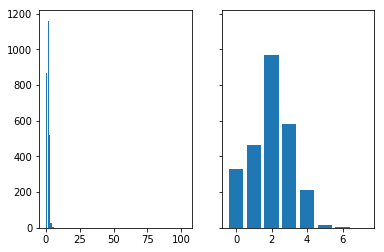

In [192]:
tree = ET.parse('iJO1366.xml')
root = tree.getroot()

species = get_species(root)
reactions = get_reactions(root)

print("Num chemical species: ", len(species))
print("Num reactions: ", len(reactions))

#graphs of counts

num_reactants = [len(x.reagents) for x in reactions]
num_products = [len(x.products) for x in reactions]
reactant_counts = count_freqs(num_reactants)
product_counts = count_freqs(num_products)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.bar(reactant_counts.keys(), reactant_counts.values())
ax2.bar(product_counts.keys(), product_counts.values())

np_reactants = np.array(num_reactants)
np_products = np.array(num_products)
        
print("Mean reactants: {0:.3f}".format(np.average(np_reactants)))
print("SD reactants: {0:.3f}".format(np.std(np_reactants)))
print("Mean products: {0:.3f}".format(np.average(np_products)))
print("SD products: {0:.3f}".format(np.std(np_products)))
        
"""
2 outliers for reactant number:
"E. coli biomass objective function (iJO1366) - WT - with 53.95 GAM estimate" - 102 reagants
"E. coli biomass objective function (iJO1366) - core - with 53.95 GAM estimate"- 68 reagants
"""


In [14]:
#need to prune this eventually - they talk about this a bit in the methods section
"""
Currency metabolites such as ATP, NAD, and H2O are ubiquitously associated with 
metabolic reactions. However, they are not incorporated into the final products. 
As pathways routing through the currency metabolites result in a biologically 
meaningless short path length, the currency metabolites were removed [24, 38, 46]. 
Similarly, transport and exchange reactions occurring at the cell boundary were 
removed, as they do not affect any relationship or reaction flow among 
intracellular reactions, while they inflate the size of the network and the 
average path length, and weaken the modular structure of intracellular connectivity.
"""
arcs = build_arcs(reactions)
print(len(arcs))

NameError: name 'build_arcs' is not defined

### Reactions from adjacency matrix

In [2]:
#automatically reads 1st sheet, which is E. coli
adjacency_matrix = pd.read_excel('12859_2019_2897_MOESM2_ESM.xlsx', index_col=0)

In [3]:
adjacency_matrix.head()

,2AGPEAT120,APH120,FA120ACPHi,FACOAE120,LPLIPAL2A120,LPLIPAL2E120,LPLIPAL2G120,2AGPGAT120,AACPS7,ACPPAT120,...,POAACR,3KGK,ASCBPL,LYXI,GOFUCR,2DGULRx,2DGULRy,3AMACHYD,DOGULNR,MSAR
2AGPEAT120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
APH120,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
FA120ACPHi,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
FACOAE120,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
LPLIPAL2A120,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
adjacency_matrix.tail()

,2AGPEAT120,APH120,FA120ACPHi,FACOAE120,LPLIPAL2A120,LPLIPAL2E120,LPLIPAL2G120,2AGPGAT120,AACPS7,ACPPAT120,...,POAACR,3KGK,ASCBPL,LYXI,GOFUCR,2DGULRx,2DGULRy,3AMACHYD,DOGULNR,MSAR
2DGULRx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2DGULRy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3AMACHYD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
DOGULNR,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
MSAR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#sanity check, all reactions are identical on both axes
all(adjacency_matrix.columns == adjacency_matrix.index)

True

In [6]:
#also disgustingly O(n^2), sorry
def build_network(adjacency_matrix):
    edges = []
    for row in adjacency_matrix.index:
        for col in adjacency_matrix.columns:
            if adjacency_matrix.at[row, col]:
                new_edge = (row.strip(), col.strip())
                edges.append(new_edge)
    return edges

In [7]:
#construct network from adjacency matrix
am_arcs = build_network(adjacency_matrix)

In [8]:
print("# Edges: ", len(am_arcs)) #should be 9099 from paper

unique_nodes = set([x[0] for x in am_arcs] + [x[1] for x in am_arcs])
print("# Nodes: ", len(unique_nodes)) #should be 1251

# Edges:  9099
# Nodes:  1251


In [21]:
#calculate degree of reaction from how many edges each rxn appears in
am_reactions = adjacency_matrix.index
degrees = {}
for am_reaction in am_reactions:
    edge_contains_react = [am_reaction in edge for edge in am_arcs]
    degrees[am_reaction] = sum(edge_contains_react)
    
sorted_reactions = sorted(degrees.keys(), key = lambda r: degrees[r], reverse=True)
print("Max degree #: {0} {1}".format(sorted_reactions[0], degrees[sorted_reactions[0]]))
print("Min degree #: {0} {1}".format(sorted_reactions[-1], degrees[sorted_reactions[-1]]))

np_degrees = np.array(list(degrees.values()))
print("Mean degree: {0:.3f}".format(np.average(np_degrees)))
print("SD degree: {0:.3f}".format(np.std(np_degrees)))
print("Degree IQR: {0:.3f}".format(np.quantile(np_degrees, 0.75)-np.quantile(np_degrees, 0.25)))

Max degree #:  ACOATA  159
Min degree #:  MSAR  1
Mean degree: 14.547
SD degree: 19.960
Degree IQR: 14.000


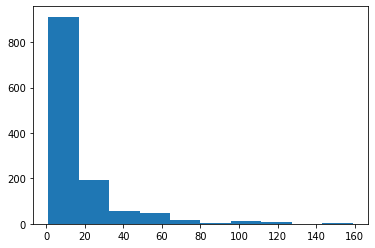

In [22]:
#degree for each node
plt.hist(degrees.values())
plt.show()

In [9]:
def read_essential(filename):
    essential_nodes = []
    with open(filename, 'r') as f:
        essential_nodes = f.read().splitlines()
    return essential_nodes

In [15]:
"""
The betweenness centrality of a node is the fraction of shortest 
paths from all nodes to all others that pass through the 
particular node.

B(i) = sum(j != k != i) sigma_jk(i)/sigma_jk

where sigma_jk is the total number of shortest paths from node j to node k
sigma_jk(i) total number of those paths that pass through node i

Implementation taken from Brandes, Ulrik (2001). "A faster 
algorithm for betweenness centrality" (PDF). Journal of
Mathematical Sociology. 25 (2): 163–177
"""  

def betweenness_centrality(all_nodes):
    bcs = {} #empty dictionary, will hold betcens
    for s in all_nodes.values():
        bcs[s] = 0 #initalize all to 0
    for j in all_nodes.values():
        S = [] #empty stack
        P = {}
        sigma = {}
        d = {}
        delta = {}
        for k in all_nodes.values():
            P[k] = [] #empty list
            sigma[k] = 0
            d[k] = -1
            delta[k] = 0 #delta[v] <- 0 for v in V
        sigma[j] = 1
        d[j] = 0
        Q = [] # empty queue
        Q.append(j) #enqueue s -> Q
        while Q:
            v = Q[0] # dequeue v <- Q
            Q.remove(v)
            S.append(v) #push v -> S
            for w in [all_nodes[x[1]] for x in v.out_edges]:
                if d[w] < 0:
                    Q.append(w) #enqueue w -> Q
                    d[w] = d[v] + 1 #update distance
                if d[w] == d[v] + 1:
                    sigma[w] += sigma[v]
                    P[w].append(v) #append v -> P[w]
        while S:
            w = S[-1] # pop w <- S
            S.remove(w)
            for v in P[w]:
                delta[v] += (sigma[v]/sigma[w])*(1+delta[w])
                if w != j:
                    bcs[w] += delta[w]
    return bcs

In [481]:
#test bridging centrality
bcs = betweenness_centrality(testNodes)

for key, val in bcs.items():
    key.between_centrality = val
    print(key.name, val)
print (testNodes['5'].bridging_centrality)

#check against Table 2, should be 0, 0, 0, 9, 8, 5, 0

1 0
2 0
3 0
4 9.0
5 8.0
6 5.0
7 0
0.0


In [16]:
#calculate
metBs = betweenness_centrality(metNodes)

#update 
for key, val in metBs.items():
    key.between_centrality = val

In [17]:
for node in sorted(metNodes.values(), key = lambda x: x.between_centrality, reverse = True):
    print (node.name, node.between_centrality)

MCOATA 437710.6808778107
POR5 246900.88901662856
ACOATA 245816.98490239013
CMPN 210906.03713595084
ALATA_L 156488.0267206719
SERAT 143834.96760270526
ASPTA 128568.80346455633
G3PD2 122376.96706596947
UAGAAT 116977.21544635858
DDPGALA 110018.74104708723
GLCATr 101944.49354803613
NTD4 100718.83882119843
TKT1 94388.49298117764
ACGS 76430.70603379078
MALTATr 76020.00180157578
MALS 75910.54885972837
DAAD 73291.52288748797
GLNS 72533.43085513658
GLYAT 70553.11616930309
CYTK1 68509.71332702073
SUCOAS 64976.655970760774
AACPS1 57937.40510747829
NDPK2 57526.60912523715
GHMT2r 57296.5126586626
AHCYSNS 53631.38939319104
DB4PS 49152.31807158691
ICDHyr 48015.29530053532
AACPS4 47581.72781450196
AOXSr2 46544.05790528874
PGI 43658.494379661926
NDPK1 43286.31433798491
ADK3 43286.31433798491
GF6PTA 42980.429478346945
METAT 42885.74607178016
AACPS2 42469.48292478061
PRPPS 42083.38727069285
ADSS 41958.53159316312
TKT2 41465.35362237365
PFL 41332.91778381407
PPS 40168.11009054585
RNTR2c2 38172.96959435175

In [ ]:
#PREVIOUS IMPLEMENTATION, TOO SLOW DON'T USE

#find shortest paths from j to all other nodes
def dijkstra(j, all_nodes):
    dists = {}
    for node in all_nodes.values():
        dists[node] = float("inf") #set all other distances to infinity
    dists[j] = 0 #distance to source vertex is 0
    queue = list(all_nodes.values())
    while queue:
        cur = sorted(queue, key = lambda x: dists[x])[0] #vertex in q w mean dist
        queue.remove(cur)
        for out_edge in cur.out_edges:
            alt = dists[cur] + 1 #weighting all edges as 1
            if alt <= dists[all_nodes[out_edge[1]]]:
                dists[all_nodes[out_edge[1]]] = alt
    return dists

def find_all_paths(length, j, k, all_nodes):
    if length == float('inf'):
        return []
    all_paths = []
    return find_all_paths_helper(length, j, [j], k, all_paths, all_nodes)
    
#enumerates all the paths, this is a dumb way to do this  
def find_all_paths_helper(length, cur_node, old_path, goal, all_paths, all_nodes):
    #catch if were already too long
    if len(old_path) > length and old_path[-1] != goal:
        return all_paths
    if old_path[-1] == goal:
        all_paths.append(old_path)
        return all_paths
    for edge in cur_node.out_edges:
        cur_node = all_nodes[edge[1]]
        cur_path = old_path.copy()
        #catch cycles
        if cur_node not in cur_path:
            cur_path.append(cur_node)
            all_paths = find_all_paths_helper(length, cur_node, cur_path, goal, all_paths, all_nodes)
    return all_paths

In [386]:
for key, value in dijkstra(testNodes['1'], testNodes).items():
    print (key.name, value)


1 0
2 1
3 1
4 1
5 2
6 3
7 4


In [395]:
def reset_bi(nodes):
    for node in nodes:
        node.between_centrality = 0

In [435]:
reset_bi(metNodes.values())

In [416]:
reset_bi(testNodes.values())

In [421]:
testNodes['5'].between_centrality

0

In [18]:
#degree_total(i)^-1/ sum of total degrees of neighbors^-1

def bridging_coefficient(node, all_nodes):
    if len(node.in_edges) == 0 and len(node.out_edges) == 0:
        return 0
    num = total_degree(node)**-1
    denom = 0
    for neighbor in set([all_nodes[edge[1]] for edge in node.out_edges] \
        + [all_nodes[edge[0]] for edge in node.in_edges]):
        denom += total_degree(neighbor)**-1
    return num/float(denom)
        
def total_degree(node):
    return len(node.in_edges) + len(node.out_edges)

In [19]:
for node in testNodes.values():
    node.bridging_coefficient = bridging_coefficient(node, testNodes)
    node.bridging_centrality = node.between_centrality * node.bridging_coefficient
    

NameError: name 'testNodes' is not defined

In [483]:
#check against known vals
for node in testNodes.values():
    print(node.name, total_degree(node), node.between_centrality, \
         + node.bridging_coefficient, node.bridging_centrality)

1 3 0 0.26666666666666666 0.0
2 2 0 0.8571428571428572 0.0
3 2 0 0.8571428571428572 0.0
4 4 9.0 0.13636363636363638 1.2272727272727275
5 2 8.0 0.8571428571428572 6.857142857142858
6 3 5.0 0.3333333333333333 1.6666666666666665
7 2 0 1.5 0.0


In [20]:
#now on metNodes
for node in metNodes.values():
    node.bridging_coefficient = bridging_coefficient(node, metNodes)
    node.bridging_centrality = node.between_centrality * node.bridging_coefficient


In [21]:
for node in sorted(metNodes.values(), key = lambda x: x.bridging_centrality, reverse = True):
    print (node.name, node.bridging_centrality)

DHNCOAS 44143.10899255916
RBFSb 12682.931699276154
MALCOAMT 11803.766611801035
RZ5PP 11771.827664612512
DHDPRy 10671.869665235608
MPTSS 10259.609460909454
RBFSa 10018.735822870512
SGSAD 9900.746670934699
HEPK2 9860.807272727272
CPMPS 8024.462388808879
3OAR100 7465.428571428572
HSK 7208.75
EDD 6903.545840428772
PPM2 6772.369593169884
ALAGLUE 6451.0342219788345
ASAD 5852.545828918367
PPCDC 5774.538573228062
DB4PS 5592.6491132061
S7PI 5525.250902083465
ADOCBIK 5393.760908942815
RNTR2c2 5279.571791765748
ALLTN 5217.50655250999
GLUTRR 5030.457142857143
KARA1 4945.60975609756
MOADSUx 4886.156008863289
G1SAT 4768.800000000001
SHKK 4705.714285714285
HMBS 4704.000000000001
XAND 4428.3777005877455
3OAR180 4411.5
3OAR120 4411.5
3OAR160 4411.5
3OAR181 4411.5
3OAR161 4411.5
3OAR80 4370.526315789474
3OAR60 4370.526315789474
3OAR141 4370.526315789474
PACCOAE 4326.411764705882
3OAR121 4325.0
OXCOAHDH 4287.80487804878
GGGABADr 4268.987880328869
3OAR40 4023.2021957913994
GLCS1 4004.210526315789
PPBNGS 3

In [41]:
bc_bins = {}
    
for node in metNodes.values():
    if node.bridging_centrality == 0:
        cur_bc = 0
    else:
        cur_bc = math.log10(node.bridging_centrality)
    rounded = round(cur_bc*2)/2
    if rounded in bc_bins.keys():
        bc_bins[rounded].append(node)
    else:
        bc_bins[rounded] = [node]

x = []
y = []
unessential = []
essential = []
for key, val in sorted(bc_bins.items(), key = lambda x: x[0]):
    x.append(key)
    y.append(sum([node.essential for node in val])/len(val))
    essential.append(sum([node.essential for node in val]))
    unessential.append(len(val) - essential[-1])
    print (key, len(val), sum([node.essential for node in val])/len(val))

-0.5 4 0.25
0.0 179 0.05027932960893855
0.5 14 0.07142857142857142
1.0 23 0.08695652173913043
1.5 49 0.1836734693877551
2.0 175 0.16
2.5 362 0.15193370165745856
3.0 312 0.24358974358974358
3.5 116 0.4396551724137931
4.0 16 0.5625
4.5 1 0.0


In [38]:
slope, intercept, r, p, stderr = scis.linregress(x, y)

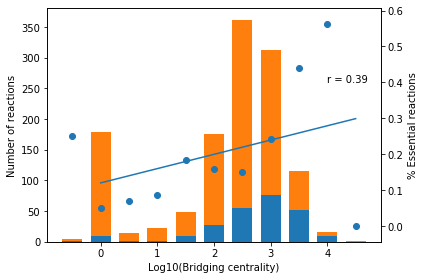

In [65]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("Log10(Bridging centrality)")
ax1.set_ylabel('Number of reactions')
ax1.bar(x, essential, 0.35)
ax1.bar(x, unessential, 0.35, bottom=essential)

ax2 = ax1.twinx()
ax2.set_ylabel("% Essential reactions")
ax2.scatter(x, y)
x_lin = np.linspace(0, 4.5, 18)
y_lin = intercept + slope*x_lin
ax2.plot(x_lin, y_lin)

r_text = "r = {:0.2f}".format(r)
ax2.text(4.0, 0.4, r_text)

fig.tight_layout()
plt.show()

In [64]:
"{:0.2f}".format(r)

'0.39'

In [402]:
list(metNodes.values())[0].name
list(metNodes.values())[0].between_centrality

0

In [193]:
for path in d:
    print(", ".join([node.name for node in path]))

1, 2, 4
1, 3, 4


In [12]:
essential_nodes = read_essential('essential_rxns.txt')

In [51]:
class MetNode:
    def __init__(self, name, essential):
        self.name = name
        self.essential = essential
        self.between_centrality = 0
        self.bridging_coefficient = 0
        self.bridging_centrality = 0
        self.in_edges = None
        self.in_out = None
    
    def find_in_edges(self, edges):
        self.in_edges = [x for x in edges if x[1] == self.name]
        
    def find_out_edges(self, edges):
        self.out_edges = [x for x in edges if x[0] == self.name]     

In [14]:
metNodes = {}
for node in unique_nodes:
    newNode = MetNode(node, node in essential_nodes)
    newNode.find_in_edges(am_arcs)
    newNode.find_out_edges(am_arcs)
    metNodes[node] = newNode #for constant access

In [266]:
len(metNodes)

1251

In [53]:
sum([node.essential for node in metNodes.values()])  
#only gets 241 compared to 246 in paper - missing 5 nodes?

241

In [49]:
metNodes.keys()

dict_keys(['ECOAH8', 'MALCOAMT', 'DMATT', 'ATPPRT', 'MAN1PT2', 'ARGTRS', 'ALDD4', '3OAR160', 'FRULYSK', 'MCITL2', 'TMPPP', 'DASYN161', 'KARA2', 'UGMDDS', 'PROTRS', 'TRE6PH', 'GDPTPDP', 'PDXPP', 'CITL', 'MLTP3', 'DUTPDP', 'EDTXS4', 'TRE6PP', 'PGLYCP', 'DAPE', 'UAPGR', 'RBP4E', 'APRAUR', 'HETZK', 'GGGABAH', 'PUNP6', 'LALDO2x', 'PRAGSr', 'KDOPS', 'ARGSL', 'PUNP5', 'ADA', 'ASPTA', 'TMDPP', 'L_LACD2', 'ACOAD1f', 'DAGK140', 'ADNK1', 'NTD10', 'DHPTPE', 'NDPK8', 'IDOND', 'SSALx', 'EAR120y', 'ACOAD4f', 'ALLPI', 'EGMEACPR', 'TMAOR1', 'G3PD7', 'LPLIPAL2G161', 'NDPK2', 'LDH_D', 'PPCDC', 'PGM', 'ACACT1r', 'PFL', 'ASPK', 'ICHORS_copy2', 'RHCCE', 'CPH4S', 'UDPGDC', 'GTPDPK', 'EDD', 'PYNP2r', 'CDAPPA181', 'GLCS1', 'MALTATr', 'FACOAE120', 'FLVRx', 'DOGULNR', 'CYTD', 'U23GAAT', 'GPDDA4', 'ALAGLUE', 'NTPTP2', 'O16GLCT1', 'CYSS', 'THRD_L', 'DTARTD', 'HEX1', 'FCI', 'NADPHQR4', '3HAD100', 'MDH2', 'FA140ACPHi', 'PRMICI', 'OMPDC', 'TRPTRS', 'M1PD', 'PFK_2', 'LPLIPAL2ATE120', 'PFK_3', 'EAR80y', 'POAACR', 'PDH'

In [72]:
for node in metNodes.values():
    if len(node.out_edges):
        print (node.name)

ECOAH8
MALCOAMT
DMATT
ATPPRT
MAN1PT2
ALDD4
3OAR160
FRULYSK
MCITL2
TMPPP
DASYN161
KARA2
UGMDDS
TRE6PH
GDPTPDP
PDXPP
CITL
MLTP3
DUTPDP
EDTXS4
TRE6PP
PGLYCP
DAPE
UAPGR
RBP4E
APRAUR
HETZK
GGGABAH
PUNP6
LALDO2x
PRAGSr
KDOPS
ARGSL
PUNP5
ADA
ASPTA
TMDPP
L_LACD2
ACOAD1f
DAGK140
NTD10
DHPTPE
NDPK8
IDOND
SSALx
EAR120y
ACOAD4f
ALLPI
EGMEACPR
TMAOR1
G3PD7
LPLIPAL2G161
NDPK2
LDH_D
PPCDC
PGM
ACACT1r
PFL
ASPK
ICHORS_copy2
RHCCE
CPH4S
UDPGDC
GTPDPK
EDD
PYNP2r
CDAPPA181
GLCS1
MALTATr
FACOAE120
FLVRx
DOGULNR
CYTD
U23GAAT
GPDDA4
ALAGLUE
NTPTP2
O16GLCT1
CYSS
THRD_L
DTARTD
HEX1
FCI
NADPHQR4
3HAD100
MDH2
FA140ACPHi
PRMICI
OMPDC
M1PD
PFK_2
LPLIPAL2ATE120
PFK_3
EAR80y
POAACR
PDH
GUAD
ACOAD3f
WCOS
R1PK
NTD12
EDTXS2
THIORDXi
MICITDr
DURIPP
O16AT
NTPP11
PRAIi
FESD1s
ACOAD7f
SELGTHR2
UPP3MT
F6PP
GCALDD
APH180
SERASr
GTHOr
GUACYC
THDPS
MCOATA
DDPGALA
DHCINDO
DKGLCNR1
AGM3PA
IMPC
GLXCL
PSSA160
CTECOAI7
I4FE4ST
FA141ACPHi
LALGP
UDPGALM
ECOAH3
CDGS
MACPD
SELGTHR3
ADK3
SPODM
PGL
ABUTD
ADSL1r
AACPS8
ASNS1
HSDy
SHSL1
NT

In [73]:
print(am_arcs[0])

('APH120', '2AGPEAT120')


In [97]:
len(metNodes['POR5'].in_edges)

91

In [388]:
testNodes = {}

tempEdges = [('1', '2'), ('1', '3'), ('1', '4'), ('2', '4'),
             ('3', '4'), ('4', '5'),('5', '6'),('6', '7'),('7', '6')]

In [389]:
for i in range(1,8):
    newNode = MetNode(str(i), False)
    newNode.find_in_edges(tempEdges)
    newNode.find_out_edges(tempEdges)
    testNodes[str(i)] = newNode

In [390]:
testNodes['4'].between_centrality

0